# Langevin Stochastic Differential Equation

A simulation of the statistical properties for the motion of a lysozyme molecule in water is presented using `yupi` classes like `Trajectory` and a `LangevinGenerator`. The simulation shows cualitatively the classical scaling laws of the Langevin theory to explain Brownian Motion (those for Mean Square Displacement or Velocity Autocorrelation Function, for instance). The notebook is structured as follows:
- Definition of parameters
- Dimenssionless equation
- Data analysis
- Plotting

In [1]:
import numpy as np
from yupi import Trajectory
from generators import LangevinGenerator
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
np.random.seed(0)

## Simulation and model parameters

In [3]:
# simulation parameters
tt_adim = 30                             # dimensionaless total time
dim = 2                                  # trajectory dimension
N = 1000                                 # number of trials
dt_adim = 1e-1                           # dimensionaless time step
n = int(tt_adim / dt_adim)               # number of time steps
t_adim = np.linspace(0, tt_adim, num=n)  # dimensionaless time array

# deterministic model parameters
N0 = 6.02e23     # Avogadro's constante [1/mol]
k = 1.38e-23     # Boltzmann's constant [J/mol.K]
T = 300          # absolute temperature [K]
eta = 1.002e-3   # water viscosity [Pa.s]
M = 14.1         # lysozyme molar mass [kg/mol] [1]
d1 = 90e-10      # semi-major axis [m] [2]
d2 = 18e-10      # semi-minor axis [m] [2]

m = M / N0                   # mass of one molecule
a = np.sqrt(d1/2 * d2/2)     # radius of the molecule
alpha = 6 * np.pi * eta * a  # Stoke's coefficient
tau = (alpha / m)**-1        # relaxation time
v_eq = np.sqrt(k * T / m)    # equilibrium thermal velocity

# intrinsic reference quantities
vr = v_eq       # intrinsic reference velocity
tr = tau        # intrinsic reference time
lr = vr * tr    # intrinsic reference length

# statistical model parameters
dt = dt_adim * tr                        # real time step
noise_pdf = 'normal'                     # noise pdf
noise_scale_adim = np.sqrt(2 * dt_adim)  # scale parameter of noise pdf
v0_adim = np.random.randn(dim, N)        # initial dimensionaless speeds

## Simulating the process

In [4]:
lg = LangevinGenerator(tt_adim, dim, N, dt_adim, v0=v0_adim)
lg.simulate()

# recovering dimensions
lg.v *= vr
lg.r *= lr
lg.t *= tr
lg.dt *= tr

trajs = lg.unpack()

## Data analysis

In [5]:
# ======= speed histogram =======
step = 1
trajs_ = [traj.sample_traj(step) for traj in trajs]
trajs_ = [traj.get_jumps(v=True) for traj in trajs_]

v_ = [traj.v for traj in trajs_]
v = np.concatenate(v_)

In [6]:
# ======= turning angles =======
theta = [traj.turning_angles() for traj in trajs]
theta = np.concatenate(theta)

In [14]:
# ======= mean square displacement =======
lag_msd = 30
lag_t_msd = dt * np.arange(lag_msd)
msd = Trajectory.get_msd(time_avg=True, lag=lag_msd)
msd_mean, msd_std = np.mean(msd, axis=1), np.std(msd, axis=1)

In [15]:
# ======= kurtosis =======
kurtosis = Trajectory.get_kurtosis(time_avg=False)

In [16]:
# ======= velocity autocorrelation function =======
lag_vacf = 50
lag_t_vacf = dt * np.arange(lag_vacf)
vacf = Trajectory.get_vacf(time_avg=True, lag=lag_vacf)
vacf_mean = np.mean(vacf, axis=1)

## Plotting

ipykernel_launcher:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


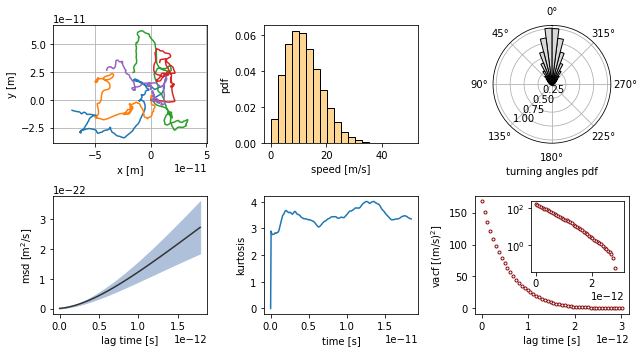

In [17]:
# ======= plotting =======
plt.figure(figsize=(9,5))

ax1 = plt.subplot(231)
for traj in trajs[:5]:
    plt.plot(traj.x, traj.y)
plt.axis('equal')
plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('y [m]')


ax2 = plt.subplot(232)
plt.hist(v, 20, density=True, ec='k', color='#fdd693')
plt.xlabel('speed [m/s]')
plt.ylabel('pdf')


ax3 = plt.subplot(233, projection='polar')
plt.hist(theta, 50, density=True, ec='k', color='.85')
ax3.set_theta_zero_location('N')
ax3.set_rlabel_position(135)
ax3.set_axisbelow(True)
plt.xlabel('turning angles pdf')


ax4 = plt.subplot(234)
plt.plot(lag_t_msd, msd_mean, color='.2')
plt.fill_between(lag_t_msd, msd_mean + msd_std, 
        msd_mean - msd_std, color='#afc0da')
plt.xlabel('lag time [s]')
plt.ylabel('$\mathrm{msd \; [m^2/s]}$')


ax5 = plt.subplot(235)
plt.plot(lg.t, kurtosis)
plt.xlabel('time [s]')
plt.ylabel('kurtosis')


ax6 = plt.subplot(236)
plt.plot(lag_t_vacf, vacf_mean, '.', color='#870e11', mfc='w')
plt.xlabel('lag time [s]')
plt.ylabel('$\mathrm{vacf \; [(m/s)^2]}$')

inset_axes(ax6, width='60%', height='60%', bbox_to_anchor=(0,0,1,1),
	bbox_transform=ax6.transAxes, loc='upper right')
plt.plot(lag_t_vacf, vacf_mean, '.', color='#870e11', mfc='w')
plt.yscale('log')

plt.tight_layout()
plt.show()

## References

[1] Berg, Howard C. Random walks in biology. Princeton University Press, 1993.

[2] Colvin, J. Ross. "The size and shape of lysozyme." Canadian Journal of Chemistry 30.11 (1952): 831-834.